# Prepare simulation

Generate a wind history for demonstration using the example FLORIS model based on the original inputs provided by Andrew

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
from scipy.stats import circmean

## Parameters

In [4]:
wind_resource_folder = Path("inputs/wind_resource_rex")

# Upsampled time step
final_time_step = 1 # in seconds

# Months of simulation (to save time for now in example)
months = 1

### Design the layout

In [5]:
# Load the grid of points
df_grid = pd.read_csv(wind_resource_folder / "wtk-led_coords.csv")
df_grid.columns = ["id", "lat", "lon"]
df_grid

,id,lat,lon
0,2271221,36.515816,-97.587830
1,2271222,36.534218,-97.587710
2,2271223,36.552628,-97.587616
3,2271224,36.571030,-97.587494
4,2271225,36.589436,-97.587370
...,...,...,...
95,2286820,36.643730,-97.403470
96,2286821,36.662140,-97.403320
97,2286822,36.680546,-97.403140
98,2286823,36.698950,-97.402954


In [6]:
# Convert lat/lon to easting and westing
def latlon_to_utm(lat, lon):
    utm_zone = int((lon + 180) / 6) + 1  # Determine UTM zone
    hemisphere = "north" if lat >= 0 else "south"
    proj_str = f"epsg:326{utm_zone}" if hemisphere == "north" else f"epsg:327{utm_zone}"
    transformer = Transformer.from_crs("epsg:4326", proj_str, always_xy=True)
    return transformer.transform(lon, lat)


# Apply transformation
df_grid[["easting", "northing"]] = df_grid.apply(
    lambda row: latlon_to_utm(row["lat"], row["lon"]), axis=1, result_type="expand"
)

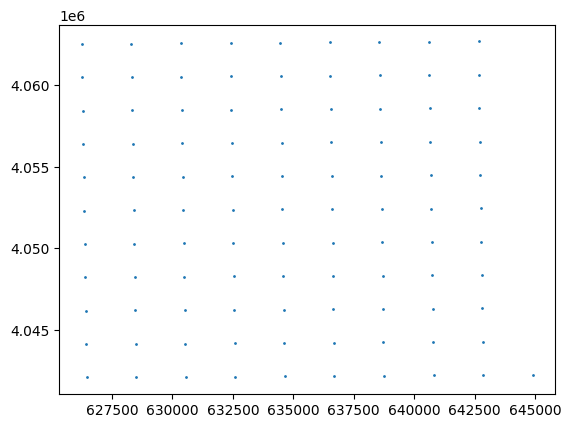

In [7]:
# Plot the grid
fig, ax = plt.subplots()
ax.scatter(df_grid.easting, df_grid.northing, s=1)

In [8]:
# What is the spacing of the grid in meters?
df_grid["easting"].diff().abs().max()

2246.4086022007978

# Design a farm with 9 turbines place within the grid

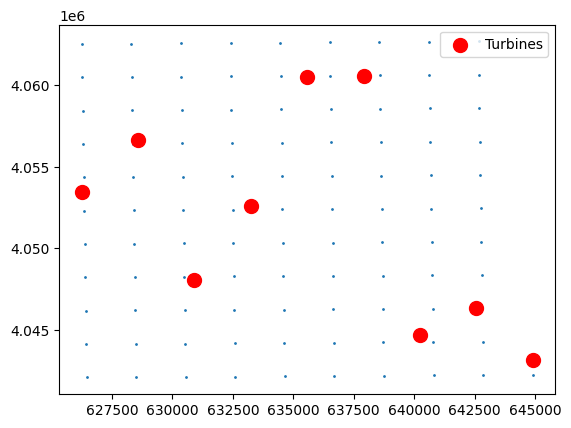

In [9]:
D = 126.0
n_turbines = 9
np.random.seed(3)  #  Fix the seed for reproducibility
min_x = df_grid.easting.min()
max_x = df_grid.easting.max()
min_y = df_grid.northing.min()
max_y = df_grid.northing.max()

# Distribute the x values evenly and the y values randomly
layout_x = np.linspace(min_x, max_x, n_turbines)
layout_y = np.random.uniform(min_y, max_y, n_turbines)

# Create the layout
fig, ax = plt.subplots()
ax.scatter(df_grid.easting, df_grid.northing, s=1)
ax.scatter(layout_x, layout_y, s=100, color="red", label="Turbines")
ax.legend()

## Print out  layout in FLORIS ready format

Then copy over to FLORIS input file (note this is already done)

In [10]:
print("  layout_x:")
for x in layout_x:
    print(f"  - {x:.1f}")

print("  layout_y:")
for y in layout_y:
    print(f"  - {y:.1f}")

  layout_x:
  - 626248.7
  - 628580.0
  - 630911.2
  - 633242.5
  - 635573.7
  - 637905.0
  - 640236.2
  - 642567.5
  - 644898.8
  layout_y:
  - 4053422.7
  - 4056660.2
  - 4048075.3
  - 4052600.3
  - 4060462.5
  - 4060531.3
  - 4044673.8
  - 4046353.9
  - 4043148.8


## For each turbine find the 4 nearest points according to df_grid and their distances

In [11]:
# For each turbine defined by layout_x/layout_y find the 4 nearest points according 
# to df_grid and their distances
df_ = df_grid.copy()
res_dict = {}
for t_i in range(n_turbines):
    x = layout_x[t_i]
    y = layout_y[t_i]
    df_["distances"] = np.sqrt((df_grid.easting - x) ** 2 + (df_grid.northing - y) ** 2)
    df_ = df_.sort_values("distances")
    indices = df_.head(4)["id"]
    distances = df_.head(4)["distances"]
    weights = 1.0 / distances
    weights /= weights.sum()
    res_dict[t_i] = {"indices": indices, "distances": distances, "weights": weights}

    print(f"  - turbine {t_i}:")
    for i, d, w in zip(indices, distances, weights):
        print(f"    - id: {i}, distance: {d:.1f}, weight: {w:.2f}")

  - turbine 0:
    - id: 2271227, distance: 921.8, weight: 0.39
    - id: 2271226, distance: 1127.7, weight: 0.31
    - id: 2273176, distance: 2326.5, weight: 0.15
    - id: 2273175, distance: 2415.6, weight: 0.15
  - turbine 1:
    - id: 2273177, distance: 339.7, weight: 0.66
    - id: 2273178, distance: 1802.1, weight: 0.12
    - id: 2275126, distance: 1844.8, weight: 0.12
    - id: 2271228, distance: 2287.8, weight: 0.10
  - turbine 2:
    - id: 2275122, distance: 460.3, weight: 0.58
    - id: 2277071, distance: 1639.0, weight: 0.16
    - id: 2275121, distance: 1906.1, weight: 0.14
    - id: 2275123, distance: 2264.5, weight: 0.12
  - turbine 3:
    - id: 2277073, distance: 780.9, weight: 0.43
    - id: 2279022, distance: 1326.6, weight: 0.25
    - id: 2277074, distance: 1954.0, weight: 0.17
    - id: 2279023, distance: 2230.1, weight: 0.15
  - turbine 4:
    - id: 2280975, distance: 959.2, weight: 0.36
    - id: 2279026, distance: 1103.1, weight: 0.32
    - id: 2280974, distance: 2

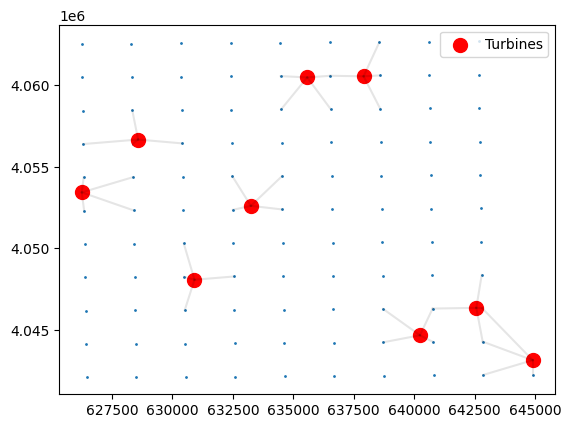

In [12]:
# Show the weight interpolation points
fig, ax = plt.subplots()
ax.scatter(df_grid.easting, df_grid.northing, s=1)
ax.scatter(layout_x, layout_y, s=100, color="red", label="Turbines")
ax.legend()

for t_i in range(n_turbines):
    x = layout_x[t_i]
    y = layout_y[t_i]
    indices = res_dict[t_i]["indices"]

    for i in indices:
        row = df_grid.loc[df_grid["id"] == i]
        ax.plot(
            [x, row["easting"].values[0]], [y, row["northing"].values[0]], color="black", alpha=0.1
        )

## Load the wind speed and direction data and project onto the turbine locations

In [13]:
df_wd = pd.read_csv(wind_resource_folder / "wdir_data_ARM-SPG_2020.csv")
df_ws = pd.read_csv(wind_resource_folder / "wspd_data_ARM-SPG_2020.csv")
df_ws.head()

,time_index,2271221,2271222,2271223,2271224,2271225,2271226,2271227,2271228,2271229,...,2286815,2286816,2286817,2286818,2286819,2286820,2286821,2286822,2286823,2288762
0,2020-01-01 00:00:00+00:00,5.23,4.96,4.81,5.29,6.02,6.14,5.89,6.03,6.54,...,5.95,5.85,6.06,6.19,5.30,4.34,4.43,4.97,5.54,6.25
1,2020-01-01 00:05:00+00:00,5.04,4.75,4.59,5.04,5.79,6.01,5.74,5.81,6.21,...,5.89,5.81,5.96,6.26,5.91,4.70,4.31,4.75,5.33,6.09
2,2020-01-01 00:10:00+00:00,4.89,4.61,4.45,4.86,5.57,5.87,5.65,5.62,5.93,...,5.82,5.73,5.86,6.10,6.26,5.27,4.37,4.53,5.08,5.95
3,2020-01-01 00:15:00+00:00,4.79,4.55,4.36,4.71,5.36,5.69,5.56,5.45,5.71,...,5.73,5.61,5.74,5.91,6.28,5.82,4.69,4.40,4.81,5.82
4,2020-01-01 00:20:00+00:00,4.75,4.55,4.35,4.61,5.17,5.49,5.42,5.28,5.50,...,5.60,5.48,5.59,5.80,6.10,6.13,5.19,4.47,4.60,5.71


In [14]:
# Build up the wind speed at each turbine location by interpolating the 4 nearest points
df_turbine_input = pd.DataFrame()
for i in range(n_turbines):
    indices = res_dict[i]["indices"].values.tolist()
    indices = [str(i) for i in indices]  # Convert to strings
    weights = res_dict[i]["weights"].values

    df_sub_ws = df_ws[indices]
    ws_t_temp = (df_sub_ws * weights).sum(axis=1)
    df_turbine_input[f"ws_{i:03d}"] = ws_t_temp

    # Same for wind direction but use circular mean
    df_sub_wd = df_wd[indices]
    wd_t_temp = df_sub_wd.apply(lambda x: circmean(x, high=360, low=0, nan_policy="omit"), axis=1)
    df_turbine_input[f"wd_{i:03d}"] = wd_t_temp

df_turbine_input.head()

,ws_000,wd_000,ws_001,wd_001,ws_002,wd_002,ws_003,wd_003,ws_004,wd_004,ws_005,wd_005,ws_006,wd_006,ws_007,wd_007,ws_008,wd_008
0,6.031061,257.404999,6.157769,258.562490,5.606109,257.392494,6.101514,255.940000,4.261485,255.317491,4.306419,256.544899,5.896658,257.552501,5.936675,257.412470,6.159643,259.890080
1,5.902177,257.227500,5.928028,258.202495,5.428744,257.154945,6.057678,256.355002,4.556338,254.404984,4.285917,253.389992,5.808878,257.500000,5.877972,256.819935,6.020549,259.627710
2,5.791961,256.692500,5.735125,257.749993,5.269193,256.412402,6.008960,256.652500,4.965629,254.440108,4.444647,251.534949,5.715097,257.192495,5.805515,256.222426,5.896190,259.230248
3,5.663322,256.424999,5.574849,257.084997,5.118673,255.757438,5.930884,256.772500,5.367886,254.895064,4.750030,251.192645,5.601462,256.987495,5.711036,255.987438,5.778442,258.962696
4,5.498655,256.307499,5.412955,256.060002,5.010408,255.039998,5.791147,256.757500,5.617785,255.302506,5.111907,251.818163,5.468949,256.730001,5.580774,256.019949,5.666116,258.780149


In [16]:
#  Complete the dataframe by adding place holder TI information for now
for i in range(n_turbines):
    df_turbine_input[f"ti_{i:03d}"] = 0.06

# Add the Timestamp column as the first column
df_turbine_input.insert(0, "Timestamp", df_ws["time_index"])

# Set the Timestamp as pd.Datetime
df_turbine_input["Timestamp"] = pd.to_datetime(df_turbine_input["Timestamp"])

# Reset indices
df_turbine_input = df_turbine_input.reset_index(drop=True)

# Show the results
df_turbine_input.head()

,Timestamp,ws_000,wd_000,ws_001,wd_001,ws_002,wd_002,ws_003,wd_003,ws_004,...,wd_008,ti_000,ti_001,ti_002,ti_003,ti_004,ti_005,ti_006,ti_007,ti_008
0,2020-01-01 00:00:00+00:00,6.031061,257.404999,6.157769,258.562490,5.606109,257.392494,6.101514,255.940000,4.261485,...,259.890080,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
1,2020-01-01 00:05:00+00:00,5.902177,257.227500,5.928028,258.202495,5.428744,257.154945,6.057678,256.355002,4.556338,...,259.627710,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
2,2020-01-01 00:10:00+00:00,5.791961,256.692500,5.735125,257.749993,5.269193,256.412402,6.008960,256.652500,4.965629,...,259.230248,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
3,2020-01-01 00:15:00+00:00,5.663322,256.424999,5.574849,257.084997,5.118673,255.757438,5.930884,256.772500,5.367886,...,258.962696,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
4,2020-01-01 00:20:00+00:00,5.498655,256.307499,5.412955,256.060002,5.010408,255.039998,5.791147,256.757500,5.617785,...,258.780149,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06


In [17]:
# Limit to the reqested number of months
start_time = df_turbine_input["Timestamp"].min()
end_time = start_time + pd.DateOffset(months=months)
initial_num_rows = df_turbine_input.shape[0]
df_turbine_input = df_turbine_input[
    (df_turbine_input["Timestamp"] >= start_time) & (df_turbine_input["Timestamp"] < end_time)
]
print(f"Reduced the number of rows from {initial_num_rows} to {df_turbine_input.shape[0]}")

Reduced the number of rows from 105408 to 8928


# Compare the wind speeds and directions of turbines 0/9 at other ends of farm

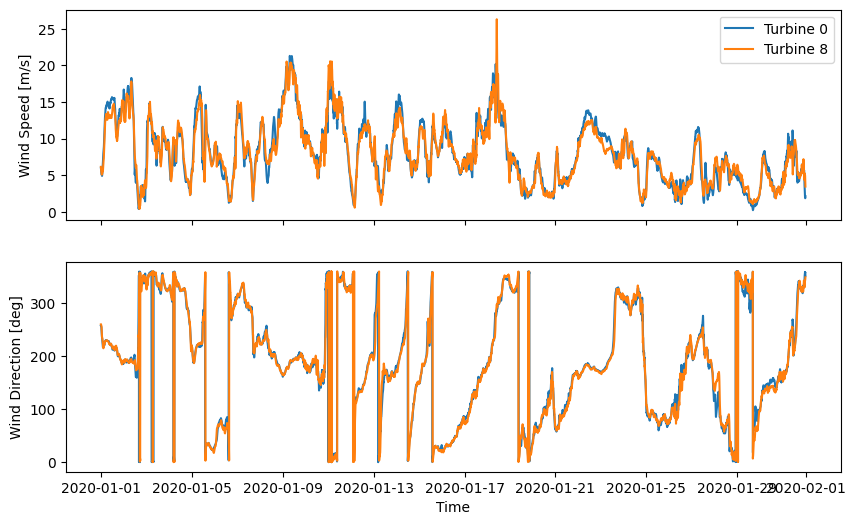

In [18]:
fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
for i in [0, 8]:
    ax = axarr[0]
    ax.plot(df_turbine_input["Timestamp"], df_turbine_input[f"ws_{i:03d}"], label=f"Turbine {i}")
    ax.set_ylabel("Wind Speed [m/s]")
    ax.legend()

    ax = axarr[1]
    ax.plot(df_turbine_input["Timestamp"], df_turbine_input[f"wd_{i:03d}"], label=f"Turbine {i}")
    ax.set_ylabel("Wind Direction [deg]")
    ax.set_xlabel("Time")

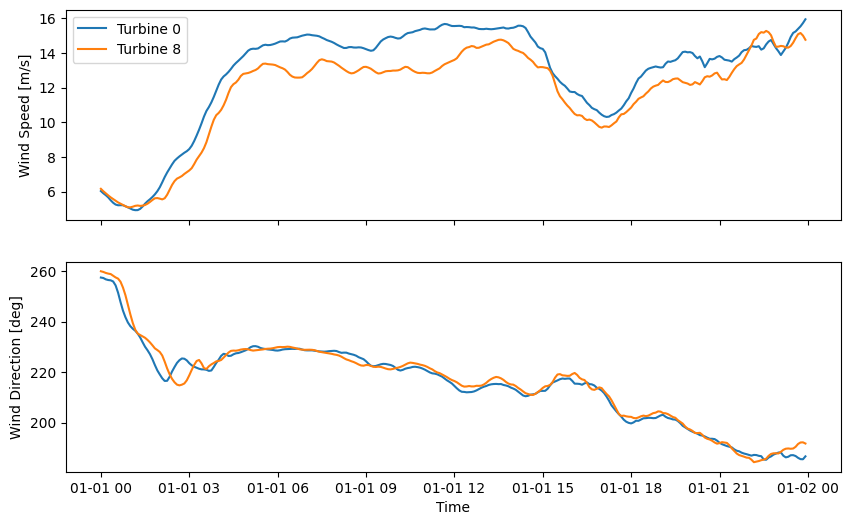

In [19]:
# Repeat above showing only the first day
fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

length_of_day = 24 * 12

for i in [0, 8]:
    ax = axarr[0]
    ax.plot(
        df_turbine_input["Timestamp"].iloc[: length_of_day],
        df_turbine_input[f"ws_{i:03d}"].iloc[: length_of_day],
        label=f"Turbine {i}",
    )
    ax.set_ylabel("Wind Speed [m/s]")
    ax.legend()

    ax = axarr[1]
    ax.plot(
        df_turbine_input["Timestamp"].iloc[: length_of_day],
        df_turbine_input[f"wd_{i:03d}"].iloc[: length_of_day],
        label=f"Turbine {i}",
    )
    ax.set_ylabel("Wind Direction [deg]")
    ax.set_xlabel("Time")

# Fake upsampling

Upsample through basically random noise, this should be improved upon

In [20]:
# Set the timestamp as the index
df_turbine_input = df_turbine_input.set_index("Timestamp")

In [21]:
# Upsample to final_time_step second intervals from 5 minutes
df_turbine_input = df_turbine_input.resample(f"{int(final_time_step)}s").ffill().bfill()

df_turbine_input.head()

,ws_000,wd_000,ws_001,wd_001,ws_002,wd_002,ws_003,wd_003,ws_004,wd_004,...,wd_008,ti_000,ti_001,ti_002,ti_003,ti_004,ti_005,ti_006,ti_007,ti_008
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,6.031061,257.404999,6.157769,258.56249,5.606109,257.392494,6.101514,255.94,4.261485,255.317491,...,259.89008,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
2020-01-01 00:00:01+00:00,6.031061,257.404999,6.157769,258.56249,5.606109,257.392494,6.101514,255.94,4.261485,255.317491,...,259.89008,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
2020-01-01 00:00:02+00:00,6.031061,257.404999,6.157769,258.56249,5.606109,257.392494,6.101514,255.94,4.261485,255.317491,...,259.89008,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
2020-01-01 00:00:03+00:00,6.031061,257.404999,6.157769,258.56249,5.606109,257.392494,6.101514,255.94,4.261485,255.317491,...,259.89008,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
2020-01-01 00:00:04+00:00,6.031061,257.404999,6.157769,258.56249,5.606109,257.392494,6.101514,255.94,4.261485,255.317491,...,259.89008,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06


### Now add random noise to each ws/wd column

In [22]:
ws_std = 0.25
wd_std = 0.5

ws_columns = [col for col in df_turbine_input.columns if col.startswith("ws_")]
wd_columns = [col for col in df_turbine_input.columns if col.startswith("wd_")]

df_turbine_input[ws_columns] += np.random.normal(0, ws_std, df_turbine_input[ws_columns].shape)
df_turbine_input[wd_columns] = (
    df_turbine_input[wd_columns] + np.random.normal(0, wd_std, df_turbine_input[wd_columns].shape)
) % 360.0

In [23]:
# Set TimeStamp as a column again
df_turbine_input = df_turbine_input.reset_index()

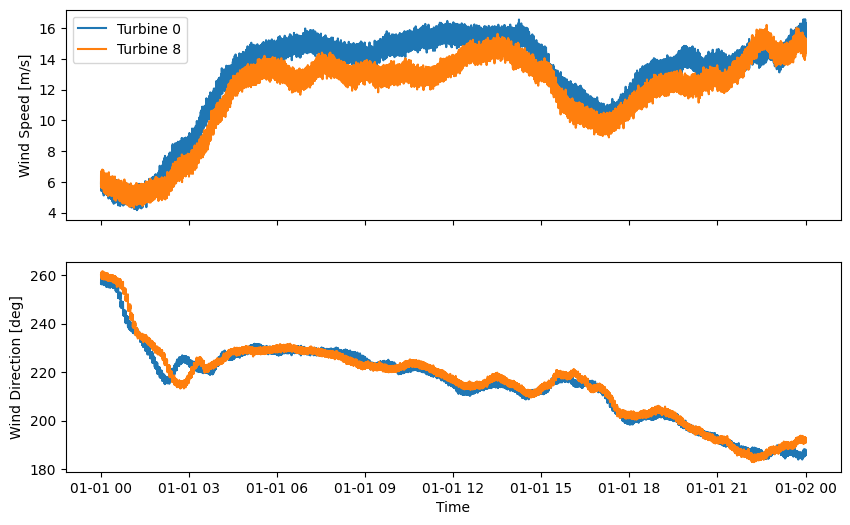

In [25]:
# Show the first day again

# Repeat above showing only the first day
fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

for i in [0, 8]:
    ax = axarr[0]
    ax.plot(
        df_turbine_input["Timestamp"].iloc[: 60 * 60 * 24],
        df_turbine_input[f"ws_{i:03d}"].iloc[: 60 * 60 * 24],
        label=f"Turbine {i}",
    )
    ax.set_ylabel("Wind Speed [m/s]")
    ax.legend()

    ax = axarr[1]
    ax.plot(
        df_turbine_input["Timestamp"].iloc[: 60 * 60 * 24],
        df_turbine_input[f"wd_{i:03d}"].iloc[: 60 * 60 * 24],
        label=f"Turbine {i}",
    )
    ax.set_ylabel("Wind Direction [deg]")
    ax.set_xlabel("Time")

## Save the data

Note this is somewhat slow

In [27]:
df_turbine_input.to_pickle("inputs/wind_input.p")